In [ ]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor

# Gathering and cleaning data from yield.csv
df_yield = pd.read_csv('/input_crops/yield.csv')  # Reading yield data
df_yield.shape  # Checking shape of the dataframe

# Renaming columns and dropping unnecessary columns
df_yield = df_yield.rename(columns={"Value": "Harvest Yield"})
df_yield = df_yield.drop(['Year Code', 'Element Code', 'Element', 'Year Code', 'Area Code', 'Domain Code', 'Domain', 'Unit', 'Item Code'], axis=1)

# Gathering and cleaning data from rainfall.csv
df_rain = pd.read_csv('/input_crops/rainfall.csv')  # Reading rainfall data
df_rain = df_rain.rename(columns={" Area": 'Area'})  # Renaming a column
df_rain['average_rain_fall_mm_per_year'] = pd.to_numeric(df_rain['average_rain_fall_mm_per_year'], errors='coerce')  # Converting column to numeric
df_rain = df_rain.dropna()  # Dropping rows with missing values

# Merging data from different sources (yield and rainfall)
yield_df = pd.merge(df_yield, df_rain, on=['Year', 'Area'])

# Gathering and cleaning data from pesticides.csv
df_pes = pd.read_csv('/input_crops/pesticides.csv')  # Reading pesticides data
df_pes = df_pes.rename(columns={"Value": "pesticides_tonnes"})  # Renaming a column
df_pes = df_pes.drop(['Element', 'Domain', 'Unit', 'Item'], axis=1)  # Dropping unnecessary columns

# Merging pesticides data with the existing yield and rainfall data
yield_df = pd.merge(yield_df, df_pes, on=['Year', 'Area'])

# Gathering and cleaning data from temp.csv
avg_temp = pd.read_csv('/input_crops/temp.csv')  # Reading temperature data
avg_temp = avg_temp.rename(columns={"year": "Year", "country": 'Area'})  # Renaming columns
yield_df = pd.merge(yield_df, avg_temp, on=['Area', 'Year'])  # Merging temperature data with the existing dataframe
yield_df.isnull().sum()  # Checking for missing values in the dataframe

Area                             0
Item                             0
Year                             0
Harvest Yield                    0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64

<ipython-input-4-5f7be439fed5>:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation_data, dtype=np.bool)


<Axes: >

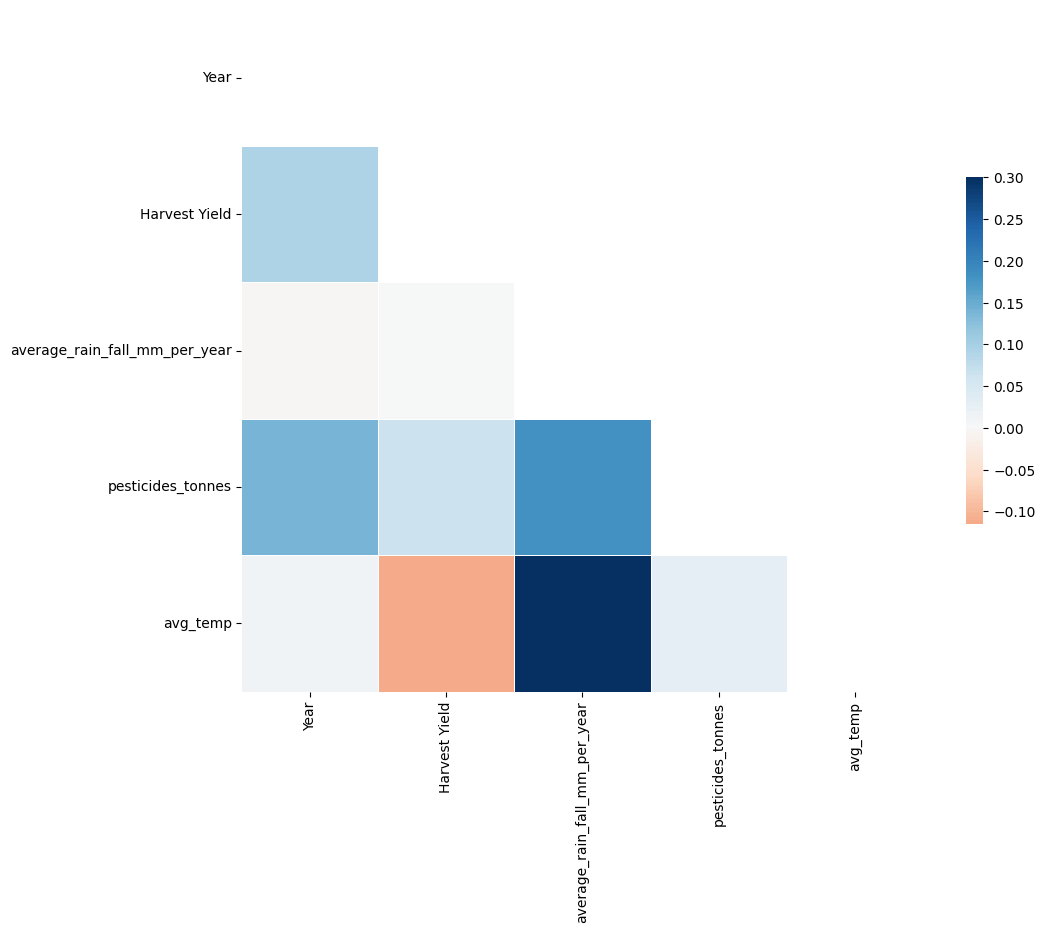

In [ ]:
# Data Exploration

yield_df.groupby('Item').count()  # Grouping 'yield_df' DataFrame by 'Item' and counting occurrences
yield_df['Area'].nunique()  # Finding the number of unique values in the 'Area' column of 'yield_df'
yield_df.groupby(['Area'],sort=True)['Harvest Yield'].sum().nlargest(10)  # Grouping 'yield_df' by 'Area', calculating the sum of 'Harvest Yield', and getting the top 10 largest sums
yield_df.groupby(['Item','Area'],sort=True)['Harvest Yield'].sum().nlargest(10) # Grouping 'yield_df' by both 'Item' and 'Area', calculating the sum of 'Harvest Yield', and getting the top 10 largest sums

# Correlation heatmap between columns of the data frame
correlation_data = yield_df.select_dtypes(include=[np.number]).corr()  # Calculating correlation matrix for numerical columns in 'yield_df'

# Creating a mask for the upper triangle of the correlation matrix
mask = np.zeros_like(correlation_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Creating a heatmap to visualize the correlation matrix
plt.figure(figsize=(11, 9))  # Setting figure size
cmap = sns.palette="RdBu"  # Choosing color palette for the heatmap

# Plotting the heatmap with specific parameters
sns.heatmap(correlation_data, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# Creating one-hot encoded columns for 'Area' and 'Item' in yield_df
yield_df_onehot = pd.get_dummies(yield_df, columns=['Area', 'Item'], prefix=['Country', 'Item'])

# Separating features and label
features = yield_df_onehot.drop(['Harvest Yield', 'Year'], axis=1)  # Extracting features
label = yield_df['Harvest Yield']  # Extracting the target variable

# Scaling the features using MinMaxScaler
scaler = MinMaxScaler()
features = scaler.fit_transform(features)  # Fit and transform the features

# Outputting the scaled features
features

array([[4.49670743e-01, 3.28894097e-04, 5.13458262e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.49670743e-01, 3.28894097e-04, 5.13458262e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.49670743e-01, 3.28894097e-04, 5.13458262e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.90028222e-01, 6.93361288e-03, 6.28960818e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.90028222e-01, 6.93361288e-03, 6.28960818e-01, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.90028222e-01, 6.93361288e-03, 6.28960818e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [ ]:
# Data Preprocessing

train_data, test_data, train_labels, test_labels = train_test_split(features, label, test_size=0.2, random_state=42)

# Function to compare different models based on R-squared score
def compare_models(model, train_data, train_labels, test_data, test_labels):
    model_name = model.__class__.__name__  # Extracting the name of the model
    fit = model.fit(train_data, train_labels)  # Fitting the model on the training data
    y_pred = fit.predict(test_data)  # Predicting with the fitted model on test data
    r2 = r2_score(test_labels, y_pred)# Calculating the R-squared score for the model
    return [model_name, r2]  # Returning the model's name and its R-squared score


# Defining different models to be compared
models = [
    GradientBoostingRegressor(n_estimators=500, max_depth=5, random_state=42),
    RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42),
    svm.SVR(kernel='rbf', C=1.0, epsilon=0.1),  # Custom SVR paramters
    DecisionTreeRegressor(max_depth=5, random_state=42)
]

In [ ]:
# Creating test_df DataFrame based on selected columns from yield_df_onehot
columns_to_select = yield_df_onehot.columns[yield_df_onehot.columns != 'Harvest Yield']
test_df = pd.DataFrame(test_data, columns=columns_to_select)

# Extracting Country Information
country_columns = [col for col in test_df.columns if 'Country' in col]
country_values = test_df[country_columns].stack()
filtered_countries = country_values[country_values > 0]

# Processing Country Information
country_indices = pd.DataFrame(filtered_countries).index.get_level_values(1)
countries = [i.split("_")[1] for i in country_indices]

# Extracting Item Information
item_columns = [col for col in test_df.columns if 'Item' in col]
item_values = test_df[item_columns].stack()
filtered_items = item_values[item_values > 0]

# Processing Item Information
item_indices = pd.DataFrame(filtered_items).index.get_level_values(1)
items = [i.split("_")[1] for i in item_indices]

clf = DecisionTreeRegressor()# Training a model (DecisionTreeRegressor) and making predictions
model = clf.fit(train_data, train_labels)# Training the DecisionTreeRegressor model using training data

# Adding 'Country' and 'Item' columns to the 'test_df' DataFrame
test_df['Country'] = countries
test_df['Item'] = items

test_df["yield_predicted"] = model.predict(test_data)# Predicting 'Harvest Yield' values using the trained model on test data
test_df["yield_actual"] = pd.DataFrame(test_labels)["Harvest Yield"].tolist()# Creating a column 'yield_actual' in 'test_df' containing actual 'Harvest Yield' values from test labels
test_group = test_df.groupby("Item")# Grouping 'test_df' by 'Item'

<ipython-input-23-84bab4e6ef74>:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(test_df["yield_actual"], test_df["yield_predicted"],


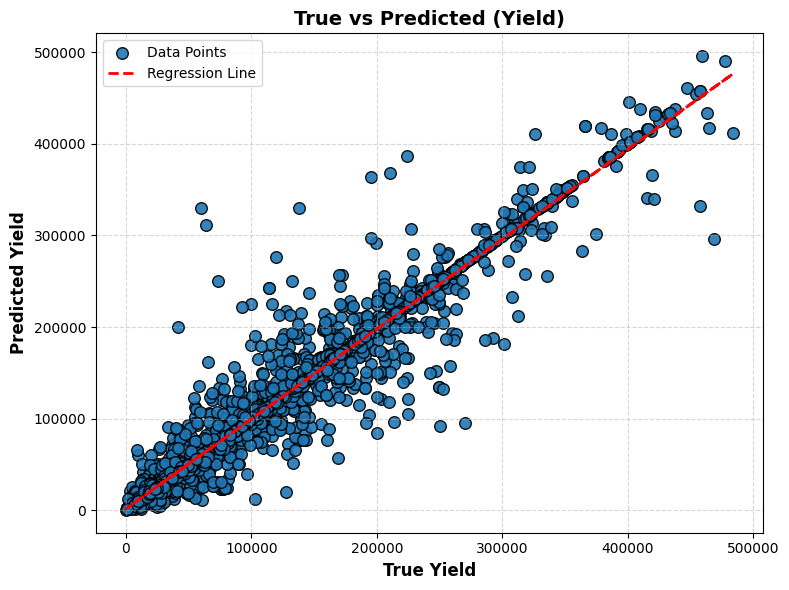

In [ ]:
# Scatter plot of True vs Predicted Yield
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size

# Scatter plot with improved aesthetics
scatter = ax.scatter(test_df["yield_actual"], test_df["yield_predicted"],
                     edgecolors='black', linewidths=1, alpha=0.9, label='Data Points',
                     cmap='viridis', s=70)  # Adjust marker size and transparency

# Adding a line of best fit (regression line) with improved style
m, b = np.polyfit(test_df["yield_actual"], test_df["yield_predicted"], 1)
regression_line, = ax.plot(test_df["yield_actual"], m * test_df["yield_actual"] + b,
                           color='red', linestyle='--', linewidth=2, label='Regression Line')

# Setting labels and title with improved font properties
ax.set_xlabel('True Yield', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Yield', fontsize=12, fontweight='bold')
ax.set_title("True vs Predicted (Yield)", fontsize=14, fontweight='bold')

# Displaying legend with improved style
ax.legend(handles=[scatter, regression_line], loc='upper left', fontsize=10)

# Customize gridlines
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

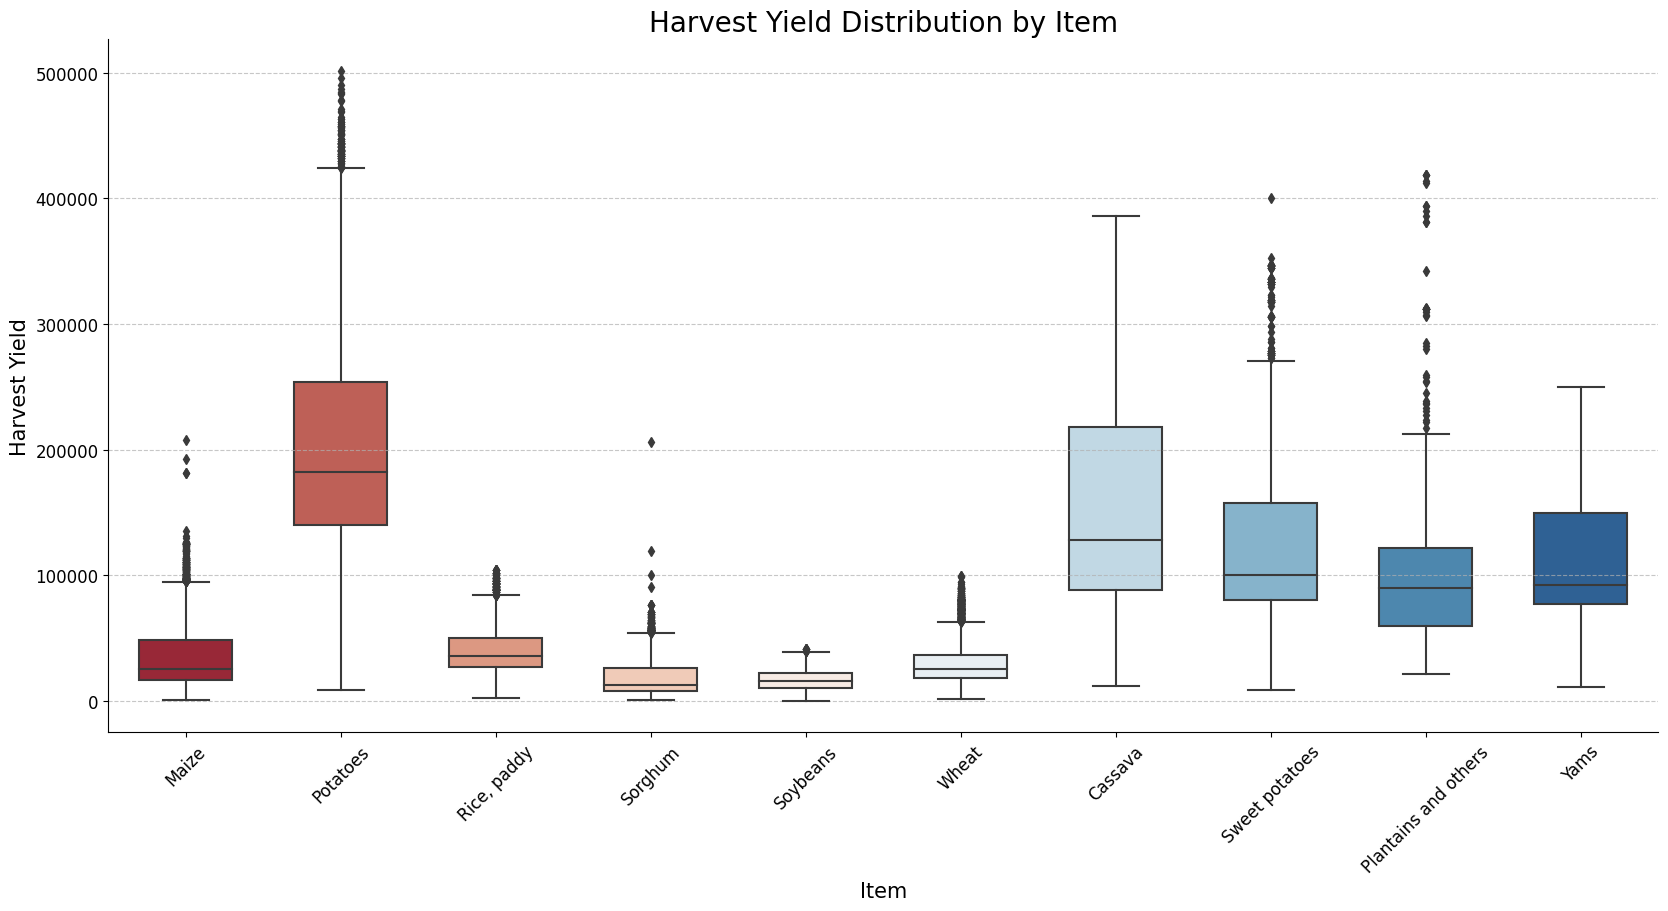

In [ ]:
# Set custom figure size
a4_dims = (20, 9)
fig, ax = plt.subplots(figsize=a4_dims)

# Adjust style and appearance of the boxplot
sns.boxplot(x="Item", y="Harvest Yield", palette="RdBu", data=yield_df, ax=ax, width=0.6)  # Adjust width for boxes
ax.set_title('Harvest Yield Distribution by Item', fontsize=20)  # Set title and adjust font size
ax.set_xlabel('Item', fontsize=15)  # Set x-axis label and adjust font size
ax.set_ylabel('Harvest Yield', fontsize=15)  # Set y-axis label and adjust font size
ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick label font size for both axes
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Adjusting borders and spines
sns.despine()  # Remove the top and right spines
ax.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines with transparency

plt.show()